In [1]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time
import os
import matplotlib.image as img
from PIL import Image

from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.losses import BinaryCrossentropy


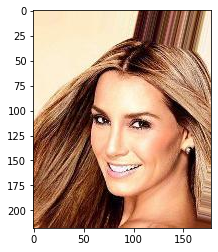

(218, 178, 3)


In [2]:
allImgPath = []
fullImgPath = "C:/Users/Belg/OneDrive - OST\Master's/02_Semester/VA/celeba/img_align_celeba"

for path in os.listdir(fullImgPath):
    if ".jpg" in path:
        allImgPath.append(os.path.join(fullImgPath,path))

image = img.imread(allImgPath[0])
plt.imshow(image)
plt.show()
print(image.shape)

In [3]:
partImgPath = allImgPath[0:100000]
cropping = (30,55,160,190)
xTrain = [np.array((Image.open(path).convert('L').crop(cropping)).resize((128,128))) for path in partImgPath]

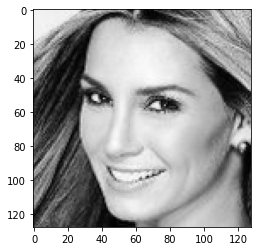

(128, 128)


In [4]:
plt.imshow(xTrain[0],cmap="gray")
plt.show()
print(xTrain[0].shape)

In [5]:
for i in range(len(xTrain)):
    xTrain[i] = xTrain[i]/127.5-1 #tanh -->[-1,1]

xTrain = np.array(xTrain)

In [6]:
#xTrain=xTrain[0:50000]
xTrain.shape

(100000, 128, 128)

<Figure size 720x720 with 0 Axes>

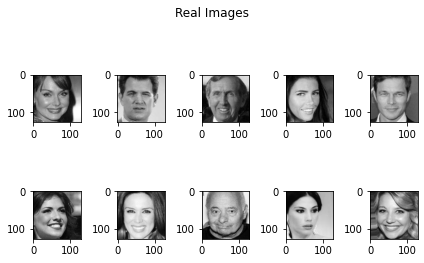

In [7]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(((xTrain[idx])* 0.5 + 0.5).reshape(128,128,1),cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [8]:
batchSize = 256
with tf.device('/CPU:0'):
    trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [92]:
nepochs = 100
zDim = 100
imgShape = (128,128,1)
sampleInterval = 1

In [10]:
def buildGenerator():

    model = Sequential()
    model.add(Dense(256 * 8 * 8, input_shape=(zDim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape([8, 8, 256]))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation="tanh"))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [11]:
buildGenerator().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      5

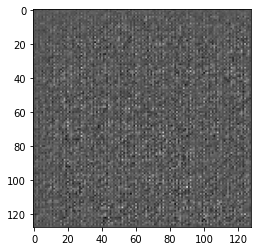

In [12]:
#generate noise image
generator = buildGenerator()

noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5,cmap="gray")
plt.show()


In [13]:
#Discriminator
def buildDiscriminator():

    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [14]:
buildDiscriminator().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)      

In [15]:
#classyfy with discriminator
discriminator = buildDiscriminator()
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[0.5001145]], shape=(1, 1), dtype=float32)


In [16]:
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [17]:
buildGan(generator,discriminator).summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 1)       2108801   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 404225    
                                                                 
Total params: 2,513,026
Trainable params: 2,479,810
Non-trainable params: 33,216
_________________________________________________________________


In [18]:
gan = buildGan(generator,discriminator)
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[0.5001145]], shape=(1, 1), dtype=float32)


In [19]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [20]:
def train_step(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])
    #for i in range(3):
    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)
    disLoss, acc = 0.5*tf.add(dreal,dfake)
    
    discriminator.trainable = False
    genLoss = gan.train_on_batch(noise,real)

      
    return genLoss,disLoss,acc*100

In [21]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [94]:
def sampleImg(generator,imgGridRow = 5, imgGridColumn = 5):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 1 is 384.0 sec
Epoch:  1 | Discriminator Loss:  0.6 | Accuracy:  88.44 % | Generator Loss:  21.71
---------------------------------------------------------------------------------------------------------------------------------------------------------------


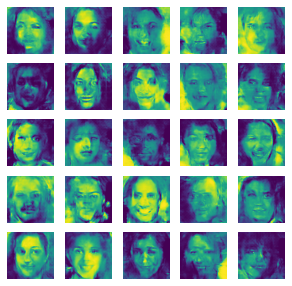

Time for epoch 2 is 383.0 sec
Epoch:  2 | Discriminator Loss:  0.06 | Accuracy:  98.12 % | Generator Loss:  10.59
---------------------------------------------------------------------------------------------------------------------------------------------------------------


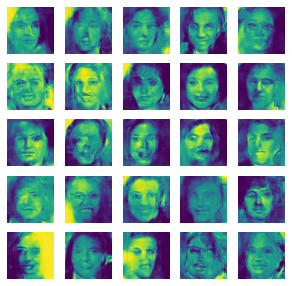

Time for epoch 3 is 384.0 sec
Epoch:  3 | Discriminator Loss:  0.02 | Accuracy:  99.06 % | Generator Loss:  15.15
---------------------------------------------------------------------------------------------------------------------------------------------------------------


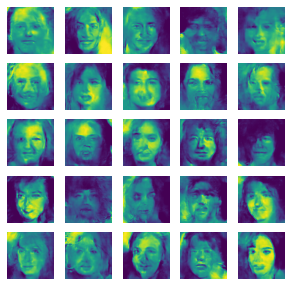

Time for epoch 4 is 383.0 sec
Epoch:  4 | Discriminator Loss:  0.16 | Accuracy:  96.56 % | Generator Loss:  12.87
---------------------------------------------------------------------------------------------------------------------------------------------------------------


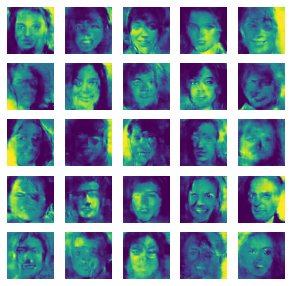

Time for epoch 5 is 385.0 sec
Epoch:  5 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  12.7
---------------------------------------------------------------------------------------------------------------------------------------------------------------


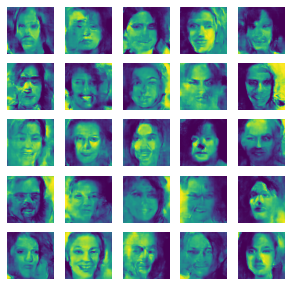

Time for epoch 6 is 377.0 sec
Epoch:  6 | Discriminator Loss:  0.07 | Accuracy:  96.88 % | Generator Loss:  19.86
---------------------------------------------------------------------------------------------------------------------------------------------------------------


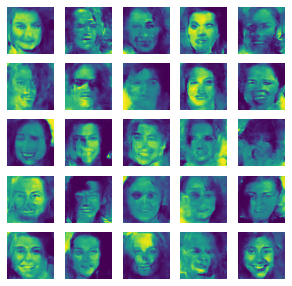

Time for epoch 7 is 376.0 sec
Epoch:  7 | Discriminator Loss:  0.06 | Accuracy:  98.44 % | Generator Loss:  17.86
---------------------------------------------------------------------------------------------------------------------------------------------------------------


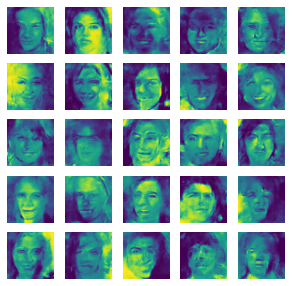

Time for epoch 8 is 380.0 sec
Epoch:  8 | Discriminator Loss:  0.01 | Accuracy:  99.69 % | Generator Loss:  18.86
---------------------------------------------------------------------------------------------------------------------------------------------------------------


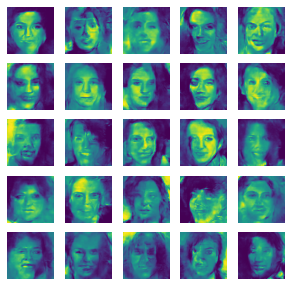

Time for epoch 9 is 380.0 sec
Epoch:  9 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  59.01
---------------------------------------------------------------------------------------------------------------------------------------------------------------


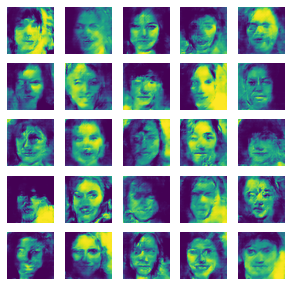

Time for epoch 10 is 380.0 sec
Epoch:  10 | Discriminator Loss:  0.01 | Accuracy:  99.38 % | Generator Loss:  13.64
---------------------------------------------------------------------------------------------------------------------------------------------------------------


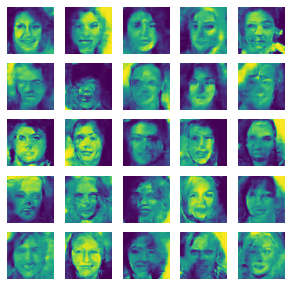

In [93]:
training()

In [95]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
generator.save("Celeb_a_CNNgenerator")

discriminator.save("Celeb_a_CNNdiscriminator")

gan.save("Celeb_a_CNNgan")

INFO:tensorflow:Assets written to: Celeb_a_CNNgenerator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNdiscriminator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNgan\assets


In [96]:
model = K.models.load_model("Celeb_a_CNNgenerator")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

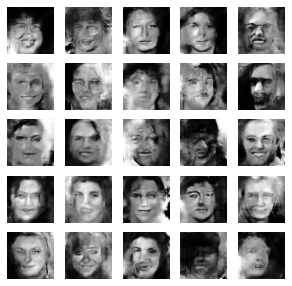

In [97]:
sampleImg(model)

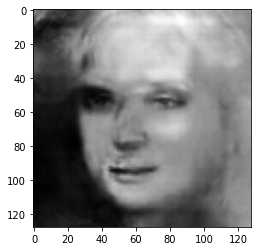

In [221]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
plt.imshow(genImg[0]* 0.5 + 0.5,cmap="gray")
plt.show()